<a href="https://colab.research.google.com/github/waltechel/KaggleStudy20220103/blob/master/chapter10/SentenceBERT_%ED%95%9C%EA%B5%AD%EC%96%B4_%EB%AC%B8%EC%9E%A5_%ED%81%B4%EB%9F%AC%EC%8A%A4%ED%84%B0%EB%A7%81_feat_%EB%B9%B5%ED%98%95%EC%9D%98%EA%B0%9C%EB%B0%9C%EB%8F%84%EC%83%81%EA%B5%AD%2C_%EC%97%98%EB%93%A0%EB%A7%81_%5B%EC%89%AC%EC%9B%80%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SentenceBERT 한국어 문장 클러스터링

유튜브 [빵형의 개발도상국](https://www.youtube.com/c/%EB%B9%B5%ED%98%95%EC%9D%98%EA%B0%9C%EB%B0%9C%EB%8F%84%EC%83%81%EA%B5%AD)

## GPU 사용 확인

메뉴 - 런타임 - 런타임 유형 변경 - 하드웨어 가속기 - GPU 확인
- 일반적으로는 Tesla K80 

In [110]:
!nvidia-smi

Thu Mar 31 12:06:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    73W / 149W |   1541MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Sentence Transformers 패키지 설치

In [111]:
!pip install -q -U sentence-transformers

## 문장 임베딩

- 한국어 문장 -> 숫자 벡터로 변환하기
- 한국어는 임베딩이 중요하다.
- 처음 한번만 다운받고 그 다음에는 바로바로 진행된다.

https://huggingface.co/jhgan/ko-sroberta-multitask

In [112]:
from sentence_transformers import SentenceTransformer

# 허깅페이스에서 해당 모델을 가져옴, 문장이나 문단을 768차원의 숫자값으로 바꿔준다.
model = SentenceTransformer('jhgan/ko-sroberta-multitask')

sentences = ["안녕하세요?", "한국어 문장 임베딩을 위한 버트 모델입니다."]
embeddings = model.encode(sentences)

print(embeddings)

[[-0.37510464 -0.7733837   0.5927709  ...  0.5792355   0.32683504
  -0.65089625]
 [-0.0936171  -0.18191506 -0.1923085  ... -0.03165798  0.30412573
  -0.26793632]]


## 클러스터링 샘플 코드

In [134]:
MAX_VALUE = 100000000000000000000000000000000000000000000000000000000000000.0
answers = []

In [135]:
def getDistance(p1, p2):
  dist = 0.0
  for i in range(0, 768):
    dist = dist + ((p1[i] - p2[i]) ** 2)
  return dist

In [136]:
def getTotalDistance(clusters, embeddings):
  global answers
  distance = 0.0
  for i in range(0, len(clusters)):
    for j in clusters[i]:
      distance += getDistance(embeddings[j], embeddings[answers[i]])
  return distance ** 0.5

In [137]:
# p는 값 하나, embeddings는 값 전체, K는 배열
def getBestCentroidOfAnswers(p, embeddings, K):
  global answers
  retIndex = 0
  retValue = MAX_VALUE
  for i in range(0, K):
    distance = getDistance(p, embeddings[answers[i]])
    if distance < retValue:
      retValue = distance
      retIndex = i
  return retIndex

In [138]:
def getBestCentroidOfCluster(p, cluster, embeddings):
  retIndex = 0
  retValue = MAX_VALUE
  for e in cluster:
    distance = getDistance(p, embeddings[e])
    if distance < retValue:
      retValue = distance
      retIndex = e
  return retIndex

In [139]:
def printAnswer(cluster, totalDistance):
  print("출력")

In [140]:
def getNextCentroidCandiofCluster(clusters, embeddings):
  average = []
  for i in range(0, 768):
    average.append(0.0)

  for cluster in clusters:
    for e in cluster:
      for i in range(0, 768):
        average[i] += embeddings[e][i]
    for i in range(0, 768):
      average[i] /= len(clusters)
  retIndex = getBestCentroidOfCluster(average, cluster, embeddings)
  return retIndex


In [150]:
import random

REPEAT = 1000
DEFAULT_VALUE = 100000
answers = []

# embeddings : (X, 768)
def kmeans(K, embeddings):
  global answers
  answers = []
  DEFAULT_VALUE = len(embeddings)
  
  for i in range(0, K):
    idx = random.randrange(0, DEFAULT_VALUE)
    isDuplicated = False
    for i in answers:
      if i == idx:
        isDuplicated = True
    if isDuplicated == False:
      answers.append(idx)

  prev = 0.0
  for i in range(0, REPEAT):
    clusters = []
    for j in range(0, K):
      clusters.append([])

    for j in range(0, DEFAULT_VALUE):
      p = embeddings[j]
      index = getBestCentroidOfAnswers(p, embeddings, K)
      clusters[index].append(j)
    
    for j in range(0, K):
      candi = getNextCentroidCandiofCluster(clusters, embeddings)
      answers[j] = candi
    totalDistance = getTotalDistance(clusters, embeddings)
    if abs(totalDistance - prev) > 0.0000001 :
      prev = totalDistance
    else:
      ret = []
      for i in range(0, len(clusters)):
        cluster = clusters[i]
        print("cluster", cluster)
        for e in cluster:
          ret.append([i, e])  
      return ret
  return 'error'
    
sample = []
for j in range(0, 9):
  test = []
  for i in range(0, 768):
    test.append(random.randrange(0, DEFAULT_VALUE))
  sample.append(test)

kmeans(3, sample)

cluster [0, 1, 2, 3, 4, 5, 6, 7, 8]
cluster []
cluster []


[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8]]

In [148]:
# 비지도학습을 위한 KMeans를 수행
from sklearn.cluster import KMeans

# Corpus with example sentences
sentences = ['한 남자가 음식을 먹는다.',
          '한 남자가 빵 한 조각을 먹는다.',
          '그 여자가 아이를 돌본다.',
          '한 남자가 말을 탄다.',
          '한 여자가 바이올린을 연주한다.',
          '두 남자가 수레를 숲 속으로 밀었다.',
          '한 남자가 담으로 싸인 땅에서 백마를 타고 있다.',
          '원숭이 한 마리가 드럼을 연주한다.',
          '치타 한 마리가 먹이 뒤에서 달리고 있다.',
          '한 남자가 파스타를 먹는다.',
          '고릴라 의상을 입은 누군가가 드럼을 연주하고 있다.',
          '치타가 들판을 가로 질러 먹이를 쫓는다.']

embeddings = model.encode(sentences)
print('embedding is ', embeddings)
print('shape of embedding is ', embeddings.shape)

# kmeans는 몇 개의 군집으로 모을 것인가를 결정한다. 
# Then, we perform k-means clustering using sklearn:
num_clusters = 5
cluster_assignment = kmeans(num_clusters, embeddings)

clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(sentences[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(cluster)
    print("")

embedding is  [[-0.28869697 -0.06496496  0.4626834  ...  0.12899679 -0.08064962
  -0.24258915]
 [-0.23551586 -0.31436378  0.13946582 ...  0.01181309 -0.34162456
  -0.29068813]
 [-0.09364879 -0.42813444 -1.0171074  ...  0.09876206 -0.5094839
   0.22941203]
 ...
 [-0.16576058  0.259785   -0.49446124 ...  0.36893126  0.122522
   0.0648507 ]
 [ 0.23439534 -0.53186923  0.3364802  ...  0.30428675 -0.39209676
   0.17232625]
 [-0.8365599  -0.11920486 -0.6205717  ...  0.16556613 -0.3440384
   0.02583572]]
shape of embedding is  (12, 768)


IndexError: ignored

# 스팀 리뷰 크롤링

### [옵션1] 빵형이 미리 크롤링한거 다운로드

'엘든링 리뷰 임베딩'으로 이동

https://github.com/kairess/KoSentenceBERT-SKT/raw/main/eldenring_stream_reviews_ko.csv

In [ ]:
import pandas as pd

df = pd.read_csv('https://github.com/kairess/KoSentenceBERT-SKT/raw/main/eldenring_stream_reviews_ko.csv')

df.head()

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access
0,111342915,"{'steamid': '76561198065764106', 'num_games_ow...",koreana,피했다고 씨발아,1646182946,1646907680,True,1196,878,0.966845,0,True,False,False
1,111348309,"{'steamid': '76561198139607001', 'num_games_ow...",koreana,이 너머 점프 유효하다 이 앞 거짓말쟁이 있다,1646189703,1646189893,True,385,211,0.954688,0,True,False,False
2,111071449,"{'steamid': '76561198032918620', 'num_games_ow...",koreana,장점은 갓겜 단점은 개적화 제어판에서 쉐이더 캐쉬 무제한 설정 관리 프로그램 설정 ...,1645880172,1645880397,True,387,3,0.924138,0,True,False,False
3,111338648,"{'steamid': '76561198411570102', 'num_games_ow...",koreana,트리가드 얘때문에 빡종하고 롤키니깐 헤카림 나와서 롤도 끔,1646177519,1646177519,True,240,265,0.904640,3,True,False,False
4,111350106,"{'steamid': '76561198045823651', 'num_games_ow...",koreana,화가나도 사랑한다 씹새야,1646191684,1646191684,True,140,45,0.868988,0,True,False,False


### [옵션2] 직접 크롤링하기

- 엘든링 리뷰: https://steamcommunity.com/app/1245620/reviews/?p=1&filterLanguage=koreana&browsefilter=toprated
- Reference: https://github.com/arditoibryan/datasets/blob/main/220226_steam/get_reviews.ipynb

In [ ]:
import requests
import time

In [ ]:
def get_reviews(appid, params={'json':1}):
        url = 'https://store.steampowered.com/appreviews/'
        response = requests.get(url=url+str(appid), params=params, headers={'User-Agent': 'Mozilla/5.0'})
        return response.json()

def get_n_reviews(appid, n=100):
    reviews = []
    cursor = '*'
    params = {
        'json' : 1,
        'filter' : 'all',
        'language' : 'koreana',
        'day_range' : 9223372036854775807,
        'review_type' : 'all',
        'purchase_type' : 'all'
    }

    while n > 0:
        time.sleep(2)
        params['cursor'] = cursor.encode()
        params['num_per_page'] = min(100, n)
        n -= 100

        response = get_reviews(appid, params)
        cursor = response['cursor']
        reviews += response['reviews']

        if len(response['reviews']) < 100: break

    return reviews

In [ ]:
reviews = get_n_reviews(1245620, 10000)

reviews[:5]

[{'author': {'last_played': 1648642058,
   'num_games_owned': 94,
   'num_reviews': 8,
   'playtime_at_review': 8099,
   'playtime_forever': 11677,
   'playtime_last_two_weeks': 2949,
   'steamid': '76561198065764106'},
  'comment_count': 0,
  'language': 'koreana',
  'received_for_free': False,
  'recommendationid': '111342915',
  'review': '피했다고 씨발아',
  'steam_purchase': True,
  'timestamp_created': 1646182946,
  'timestamp_updated': 1646907680,
  'voted_up': True,
  'votes_funny': 958,
  'votes_up': 1327,
  'weighted_vote_score': '0.967764079570770264',
  'written_during_early_access': False},
 {'author': {'last_played': 1648557334,
   'num_games_owned': 168,
   'num_reviews': 57,
   'playtime_at_review': 612,
   'playtime_forever': 2763,
   'playtime_last_two_weeks': 890,
   'steamid': '76561198139607001'},
  'comment_count': 0,
  'language': 'koreana',
  'received_for_free': False,
  'recommendationid': '111348309',
  'review': '이 너머, 점프 유효하다\n\n이 앞, 거짓말쟁이 있다',
  'steam_purchase':

In [ ]:
import pandas as pd

df = pd.DataFrame.from_dict(reviews)

df.head()

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access
0,111342915,"{'steamid': '76561198065764106', 'num_games_ow...",koreana,피했다고 씨발아,1646182946,1646907680,True,1327,958,0.967764079570770264,0,True,False,False
1,111348309,"{'steamid': '76561198139607001', 'num_games_ow...",koreana,"이 너머, 점프 유효하다\n\n이 앞, 거짓말쟁이 있다",1646189703,1646189893,True,432,230,0.958864212036132813,0,True,False,False
2,111071449,"{'steamid': '76561198032918620', 'num_games_ow...",koreana,장점은 갓겜\n\n단점은 개적화;;;\n\nNVIDIA 제어판에서 쉐이더 캐쉬 =>...,1645880172,1645880397,True,409,3,0.924968481063842773,0,True,False,False
3,111338648,"{'steamid': '76561198411570102', 'num_games_ow...",koreana,트리가드 얘때문에 빡종하고 롤키니깐 헤카림 나와서 롤도 끔ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ,1646177519,1646177519,True,267,286,0.911553919315338135,3,True,False,False
4,111350106,"{'steamid': '76561198045823651', 'num_games_ow...",koreana,화가나도 사랑한다 씹새야,1646191684,1646191684,True,159,52,0.870864331722259521,0,True,False,False


## 전처리

- 한글이 아닌 글자 제거
- 작은따옴표 제거
- 연속된 공백 제거
- 좌우 공백 제거
- 최대 글자 255자

In [ ]:
df['review'] = df['review'] \
  .replace(r'[^가-힣 ]', ' ', regex=True) \
  .replace("'", '') \
  .replace(r'\s+', ' ', regex=True) \
  .str.strip() \
  .str[:255]

df.head()

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access
0,111342915,"{'steamid': '76561198065764106', 'num_games_ow...",koreana,피했다고 씨발아,1646182946,1646907680,True,1327,958,0.967764079570770264,0,True,False,False
1,111348309,"{'steamid': '76561198139607001', 'num_games_ow...",koreana,이 너머 점프 유효하다 이 앞 거짓말쟁이 있다,1646189703,1646189893,True,432,230,0.958864212036132813,0,True,False,False
2,111071449,"{'steamid': '76561198032918620', 'num_games_ow...",koreana,장점은 갓겜 단점은 개적화 제어판에서 쉐이더 캐쉬 무제한 설정 관리 프로그램 설정 ...,1645880172,1645880397,True,409,3,0.924968481063842773,0,True,False,False
3,111338648,"{'steamid': '76561198411570102', 'num_games_ow...",koreana,트리가드 얘때문에 빡종하고 롤키니깐 헤카림 나와서 롤도 끔,1646177519,1646177519,True,267,286,0.911553919315338135,3,True,False,False
4,111350106,"{'steamid': '76561198045823651', 'num_games_ow...",koreana,화가나도 사랑한다 씹새야,1646191684,1646191684,True,159,52,0.870864331722259521,0,True,False,False


## 전처리2

아무것도 안써있는 리뷰 제거

In [ ]:
df = df[df['review'].str.strip().astype(bool)]

len(df)

394

마지막으로 확인

In [ ]:
df['review'].values.tolist()[:5]

['피했다고 씨발아',
 '이 너머 점프 유효하다 이 앞 거짓말쟁이 있다',
 '장점은 갓겜 단점은 개적화 제어판에서 쉐이더 캐쉬 무제한 설정 관리 프로그램 설정 엘든링 추가 전원 관리 모드를 최고 성능 선호 카메라 조작중 스터터링 증상 모두 사라짐',
 '트리가드 얘때문에 빡종하고 롤키니깐 헤카림 나와서 롤도 끔',
 '화가나도 사랑한다 씹새야']

## CSV 파일로 저장

In [ ]:
df.to_csv('eldenring_stream_reviews_ko.csv', index=False)

## 엘든링 리뷰 임베딩

In [ ]:
corpus = df['review'].values.tolist()

embeddings = model.encode(corpus)

embeddings[:5]

array([[-0.22529417, -0.41753626,  0.6130392 , ..., -0.10349625,
        -0.7012687 , -0.5617138 ],
       [-0.9064568 ,  0.02967472,  1.02179   , ...,  0.2281066 ,
        -0.0695185 ,  0.10106523],
       [-0.19821419,  0.33884296,  0.4552719 , ...,  0.09432784,
         0.0760655 ,  0.00539286],
       [-0.3279998 ,  0.11018913,  0.8197105 , ..., -0.08382764,
        -0.6934301 , -0.56813014],
       [-0.18077028,  0.00652904,  0.0143102 , ...,  0.27408385,
        -0.25302637, -0.75834966]], dtype=float32)

## k=3 클러스터링

In [ ]:
num_clusters = 3
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(embeddings)
cluster_assignment = clustering_model.labels_

clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(corpus[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print('Cluster %d (%d)' % (i+1, len(cluster)))
    print(cluster)
    print('')

Cluster 1 (89)
['이 너머 점프 유효하다 이 앞 거짓말쟁이 있다', '엘든 링인 것 같지', '트리가드 씨벨럼아', '한대만', '목표는 구멍 그리고 씨앗 바쳐라', '오늘도 나는 그들에게 메세지를 남긴다 이 너머 숨겨진 길 있다', '언제 나오나요', '엘든링 최적화좀', '아이 엠 말레니아 블레이드 오브 미켈라 아이 엠 말레이나 블레이드 오브 미켈라 아이 엠 말레이나 블레이드 오브 미켈라 아이 엠 말레이나 블레이드 오브 미켈라 아이 엠 말레이나 블레이드 오브 미켈라 아이 엠 말레이나 블레이드 오브 미켈라 아이 엠 말레이나 블레이드 오브 미켈라 아이 엠 말레이나 블레이드 오브 미켈라 아이 엠 말레이나 블레이드 오브 미켈라 아이 엠 말레이나 블레이드 오브 미켈라 아이 엠 말레이나 블레이드 오브 미켈라 아이 엠 말레이나 블레이', '잘만든 스꼴라', '이 너머 기쁨 있다 즉 엘든 링 오오 엘든 링', '존나재밌네뒤질래', '오픈크리틱 점', '나는 엘데의 진정한 왕이다', '시발 날 엘든링 속으로 보내줘', '컴퓨터에서 김포공항 소리남', '무기 양손잡기 는 왼쪽 마우스 클릭 입니다', '사양 충분히 맞췄는데 프레임 시발년들아', '오픈월드 스꼴라 근데 이제 재미를 곁들인', '갓겜', '어려워서 재미있네요', '다크소울 잖아요 이게 왜 마스터피스', '재밌어용', '전나맵네', '프레임빼면 맛있네요', '이 앞 엘든링 엘든링 엘든링 엘든링 엘든링 엘든링 엘든링 엘든링 엘든링 엘든링 엘든링 엘든링 엘든링 엘든링 엘든링 엘든링 엘든링 엘든링 엘든링 엘든링 엘든링 엘든링 엘든링 엘든링 엘든링 엘든링 엘든링 엘든링 엘든링 엘든링 엘든링 엘든링 엘든링 있다 따라서 갓겜 있음', '보크를 엘데의 왕으로', '좇노잼', '이게 년 게임', '슬슬 갓겜같으면 개추', '이 앞 좆같음 있다', '오오오 스터터 링 스터터 링 엘든 링', '이것이야 말로 갓겜이다', '오픈월드에서 펼쳐지는 유다희와 연애시뮬레이션 이 곳에 구멍 하지만 손가락', '최적화나 되었으면',

# 워드클라우드 그리기

## 형태소 분석, 명사 추출

In [ ]:
!pip install -q konlpy tqdm

     |████████████████████████████████| 19.4 MB 1.4 MB/s 
     |████████████████████████████████| 448 kB 44.9 MB/s 


In [ ]:
from konlpy.tag import Komoran, Okt, Kkma, Hannanum
from tqdm import tqdm

extractor = Hannanum()

nouns = []

for review in tqdm(df['review'].values.tolist()):
    nouns.extend(extractor.nouns(review))

len(nouns)

100%|██████████| 394/394 [00:14<00:00, 26.33it/s]


6344

In [ ]:
from collections import Counter

count = Counter(nouns)
words = dict(count.most_common())

for i, (word, count) in enumerate(words.items()):
    if i > 10:
        break

    print(word, count)

게임 187
엘든링 128
것 108
오오 71
수 66
최적화 63
다크소울 61
나 60
소울 57
프레임드랍 48
오픈월드 43


## 한글 폰트 다운로드

In [ ]:
!wget https://github.com/kairess/MBTI-wordcloud/raw/master/NanumSquareRoundR.ttf

--2022-03-30 16:58:08--  https://github.com/kairess/MBTI-wordcloud/raw/master/NanumSquareRoundR.ttf
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kairess/MBTI-wordcloud/master/NanumSquareRoundR.ttf [following]
--2022-03-30 16:58:08--  https://raw.githubusercontent.com/kairess/MBTI-wordcloud/master/NanumSquareRoundR.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1063276 (1.0M) [application/octet-stream]
Saving to: ‘NanumSquareRoundR.ttf’

NanumSquareRoundR.t 100%[===================>]   1.01M  --.-KB/s    in 0.05s   

2022-03-30 16:58:08 (20.5 MB/s) - ‘NanumSquareRoundR.ttf’ saved [1063276

## 워드클라우드 그리기

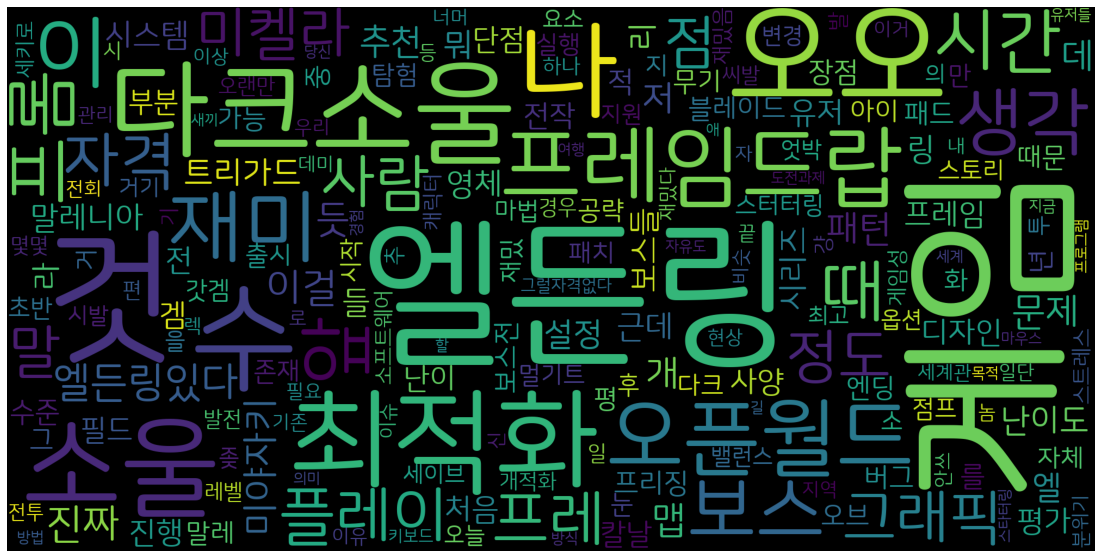

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(
    font_path='NanumSquareRoundR.ttf',
    width=2000,
    height=1000
).generate_from_frequencies(words)

plt.figure(figsize=(20, 10))
plt.imshow(wc)
plt.axis('off')
plt.show()

# 기타

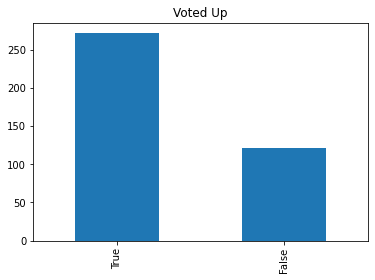

In [ ]:
df['voted_up'].value_counts().plot(kind='bar', title='Voted Up')

In [ ]:
import json

total_playtime = 0

for i in range(len(df)):
    playtime = json.loads(df.iloc[i]['author'].replace("\'", "\""))['playtime_forever']

    total_playtime += playtime

print('전체 플레이타임 합계 (분)', total_playtime)
print('전체 플레이타임 합계 (시간)', total_playtime / 60)
print('평균 플레이타임 (시간)', total_playtime / len(df) / 60)

AttributeError: ignored

In [ ]:
print('빛바랜 자 화이팅!')